In [1]:
import pandas as pd
import numpy as np
import edward as ed
import keras 
import matplotlib.pyplot as plt
import seaborn as sns

from edward.models import Normal
from keras.models import Sequential, load_model
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline
sns.set_style('white')

/Users/zihaoxu/ENTER/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
white = pd.read_csv('../data/white.csv')
red = pd.read_csv('../data/red.csv')

(array([ 37., 808., 969., 761., 765., 625., 427., 368., 110.,  28.]),
 array([ 8.  ,  8.62,  9.24,  9.86, 10.48, 11.1 , 11.72, 12.34, 12.96,
        13.58, 14.2 ]),
 <a list of 10 Patch objects>)

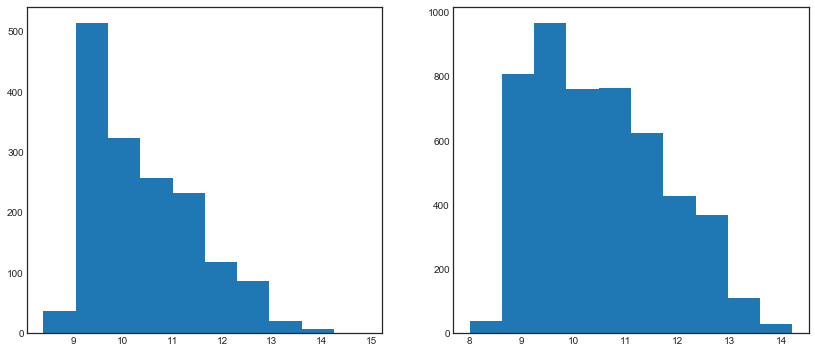

In [5]:
fig, ax = plt.subplots(1,2, figsize = (14,6))

ax[0].hist(red['alcohol'], 10)
ax[1].hist(white['alcohol'], 10)

## Data preprocessing

In [6]:
red['type'] = 1
white['type'] = 0

wines = red.append(white, ignore_index = True)
print(wines.shape)

(6497, 13)


In [7]:
wines = wines[list(wines.corr()['type'].sort_values(ascending = False).index)]

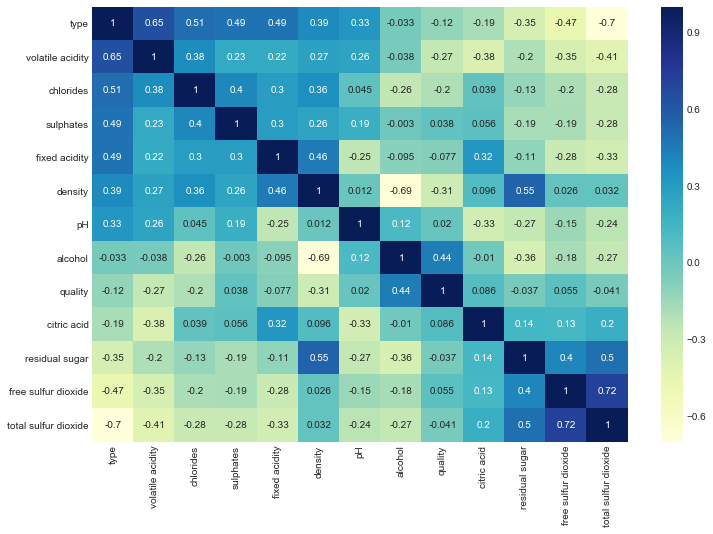

In [8]:
corr = wines.corr()
plt.figure(figsize = (12,8))
ax = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap = "YlGnBu",
            annot = True)
plt.savefig('../plots/corr', fmt = 'png', dpi = 300)
plt.show()

In [9]:
Features = np.array(wines[[c for c in wines.columns if c!='type']])
Labels = np.array(wines[['type']])

X_train, X_test, y_train, y_test = train_test_split(Features, Labels, test_size = .5, random_state = 42)

In [10]:
scalar = StandardScaler().fit(X_train)

X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

min_lengh = min(X_train.shape[0], X_test.shape[0])
X_train = X_train[:min_lengh, ]
y_train = y_train[:min_lengh, ]
X_test = X_test[:min_lengh, ]
y_test = y_test[:min_lengh, ]

In [11]:
print(X_train.shape)
print(X_test.shape)

(3248, 12)
(3248, 12)


## Train the Keras Sequntial Model

In [12]:
model = Sequential()
model.add(Dense(12, activation = "relu", input_shape = (12,)))
model.add(Dense(8, activation = "relu"))
model.add(Dense(8, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.output_shape

(None, 1)

## Compile and Train

In [15]:
file_path = 'model_file.h5'
early_stopping_monitor = EarlyStopping(patience = 2)
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Complies
adam = keras.optimizers.Adam(lr=0.0005)
model.compile(loss = "binary_crossentropy",
             optimizer = adam,
             metrics = ['accuracy'])

In [16]:
history = model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs = 20, 
                    batch_size = 4, 
                    callbacks = [early_stopping_monitor, checkpoint],
                    verbose = 1)

Train on 2598 samples, validate on 650 samples
Epoch 1/20
2598/2598 [==============================] - 2s 722us/step - loss: 0.2941 - acc: 0.8626 - val_loss: 0.1298 - val_acc: 0.9846

Epoch 00001: val_loss improved from inf to 0.12984, saving model to model_file.h5
Epoch 2/20
2598/2598 [==============================] - 2s 590us/step - loss: 0.0747 - acc: 0.9865 - val_loss: 0.0497 - val_acc: 0.9938

Epoch 00002: val_loss improved from 0.12984 to 0.04973, saving model to model_file.h5
Epoch 3/20
2598/2598 [==============================] - 1s 480us/step - loss: 0.0408 - acc: 0.9896 - val_loss: 0.0398 - val_acc: 0.9969

Epoch 00003: val_loss improved from 0.04973 to 0.03982, saving model to model_file.h5
Epoch 4/20
2598/2598 [==============================] - 1s 520us/step - loss: 0.0317 - acc: 0.9923 - val_loss: 0.0361 - val_acc: 0.9969

Epoch 00004: val_loss improved from 0.03982 to 0.03609, saving model to model_file.h5
Epoch 5/20
2598/2598 [==============================] - 1s 504us/

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


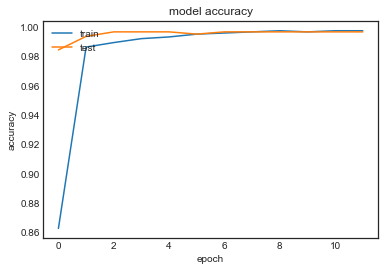

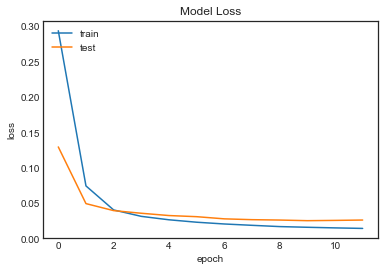

In [31]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('../plots/loss_nn', fmt = 'png', dpi = 300)
plt.show()

In [17]:
model = load_model(file_path)

In [25]:
# Prediction
y_pred = model.predict(X_test)
y_pred = [np.round(i[0]) for i in y_pred]

In [30]:
score = model.evaluate(X_test, y_test, verbose = 0)
print("Test loss:", score[0])
print("Test acc:", score[1])

Test loss: 0.029343007963949015
Test acc: 0.9947660098522167


Test acc: 0.9947660098522167


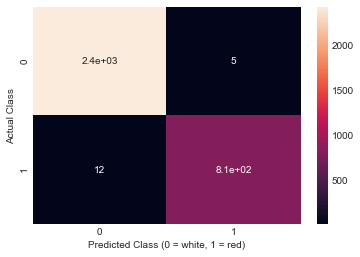

In [32]:
conf = confusion_matrix(y_test, y_pred)
print("Test acc:", (conf[0][0] + conf[1][1])/np.sum(conf))
sns.heatmap(conf, annot = True)
plt.xlabel("Predicted Class (0 = white, 1 = red)")
plt.ylabel("Actual Class")
plt.savefig('../plots/conf_nn', fmt = 'png', dpi = 300)
plt.show()